In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [17]:
#  pip install --upgrade scipy networkx

In [2]:
hero_net = pd.read_csv(r"C:\Users\Marina\OneDrive\Desktop\archive\hero-network.csv")
edges = pd.read_csv(r"C:\Users\Marina\OneDrive\Desktop\archive\edges.csv")
nodes = pd.read_csv(r"C:\Users\Marina\OneDrive\Desktop\archive\nodes.csv")

In [3]:
nodes

,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero
...,...,...
19085,"ZOTA, CARLO",hero
19086,ZOTA,hero
19087,ZURAS,hero
19088,ZURI,hero


In [4]:
comic = nodes[(nodes['type'] == 'comic')]
hero = nodes[(nodes['type'] == 'hero')]

In [5]:
hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


In [6]:
hero_net["hero1"] = hero_net["hero1"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
hero_net["hero2"] = hero_net["hero2"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [7]:
hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [8]:
edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [9]:
edges["hero"] = edges["hero"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [10]:
edges

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


In [11]:
hero = set(edges.hero)
hero_union = set(hero_net.hero1).union(set(hero_net.hero2))

diff = hero_union - hero.intersection(hero_union)
diff

{'SPIDER-MAN/PETER PAR'}

In [12]:
def jaccard_similarity(setA, setB):
    ''' 
    This function simply computes the Jaccard similarity from its definition.
    '''
    return len(set(setA).intersection(setB))/len(set(setA).union(setB))

In [13]:
for hero in set(edges.hero):
    for elem in diff:
        sim = jaccard_similarity(set(elem), set(hero))
        if sim >= 0.5:
            hero_net = hero_net.replace(elem, hero)

hero_net

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE
574464,CALLISTO,CALIBAN
574465,CALIBAN,ROGUE


In [14]:
# validation
hero = set(edges.hero)
hero_union = set(hero_net.hero1).union(set(hero_net.hero2))

diff = hero_union - hero.intersection(hero_union)
diff

set()

In [15]:
print(len(hero_union), len(hero.intersection(hero_union))) # all heroes' names in 'hero-network.csv' are now found in 'edges.csv'

6420 6420


In [16]:
G_hero_net = nx.MultiGraph()

In [17]:
hero_net.apply(lambda row: G_hero_net.add_edge(row['hero1'], row['hero2']), axis=1)

0          0
1          0
2          0
3          1
4          1
          ..
574462    27
574463    22
574464     8
574465    11
574466     1
Length: 574467, dtype: int64

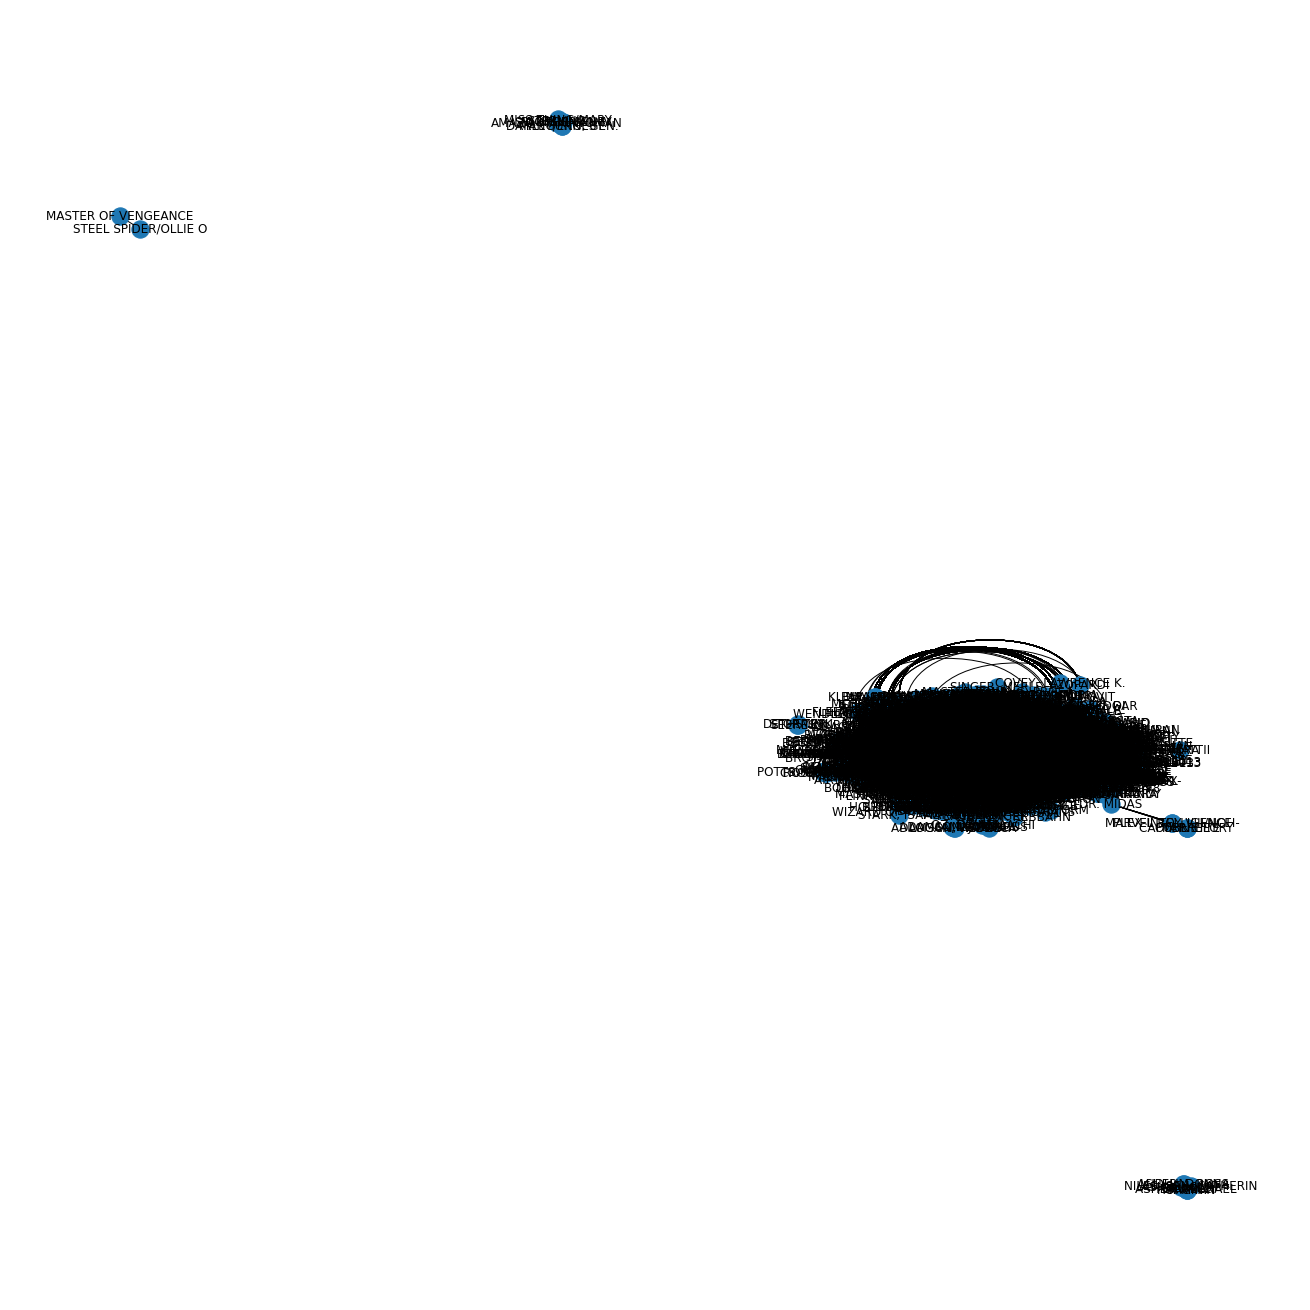

In [18]:
fig = plt.figure(figsize=(18,18))
nx.draw(G_hero_net, with_labels=True,node_size=300)
plt.show()

In [19]:
print("Total number of nodes: ", int(G_hero_net.number_of_nodes()))
print("Total number of edges: ", int(G_hero_net.number_of_edges()))

Total number of nodes:  6298
Total number of edges:  574467


In [22]:
print("Degree for all nodes: ", list(G_hero_net.degree())[:20])

Degree for all nodes:  [('LITTLE, ABNER', 44), ('PRINCESS ZANDA', 30), ("BLACK PANTHER/T'CHAL", 3677), ('STEELE, SIMON/WOLFGA', 21), ('FORTUNE, DOMINIC', 47), ('ERWIN, CLYTEMNESTRA', 186), ('IRON MAN/TONY STARK', 11817), ('IRON MAN IV/JAMES R.', 2182), ('RAVEN, SABBATH II/EL', 26), ('CARNIVORE/COUNT ANDR', 121), ('GHOST', 66), ('ZIMMER, ABE', 232), ('FU MANCHU', 217), ('TARR, BLACK JACK', 436), ('SMITH, SIR DENIS NAY', 377), ('SHANG-CHI', 741), ('STARSHINE II/BRANDY', 550), ('ROM, SPACEKNIGHT', 676), ('MAN-THING/THEODORE T', 401), ('WU, LEIKO', 406)]


In [23]:
print("Total number of self-loops: ", int(nx.number_of_selfloops(G_hero_net)))
print("List of all nodes with self-loops: ",
             list(nx.nodes_with_selfloops(G_hero_net)))

Total number of self-loops:  2234
List of all nodes with self-loops:  ['SUB-MARINER/NAMOR MA', 'CAPTAIN AMERICA', 'GORGON [INHUMAN]', 'BUCKY/BUCKY BARNES', 'WHIZZER/ROBERT L. FR', 'MISS AMERICA/MADELIN', 'PATRIOT/JEFF MACE', 'BLUE DIAMOND/PROFESS', 'VINDICATOR II DOPPEL', 'SILVER SCORPION/ELIS', 'RAVONNA LEXUS RENSLA', 'FIN/PETER NOBLE', 'MISTY/VINCENTE', 'DR. STRANGE DOPPELGA']


In [24]:
print("List of all nodes we can go to in a single step from some node: ",
                                                 list(G_hero_net.neighbors('LITTLE, ABNER')))

List of all nodes we can go to in a single step from some node:  ['PRINCESS ZANDA', "BLACK PANTHER/T'CHAL", 'CARNIVORE/COUNT ANDR', 'IRON MAN/TONY STARK', 'GOLDEN-BLADE', 'DIXON, GENERAL', 'IRON MAN IV/JAMES R.', 'JOCASTA', 'FUJIKAWA, RUMIKO', 'MADAME MENACE/SUNSET', 'JACOBS, GLENDA', 'WAR MACHINE II/PARNE', 'SAPPER', 'HOGAN, VIRGINIA PEPP', 'BINARY/CAROL DANVERS', 'FIN FANG FOOM/MIDGAR', 'MANN, DR. J. VERNON', 'THOR/DR. DONALD BLAK', 'TEMPEST II/NICOLETTE', 'JARVIS, EDWIN', 'INFERNO III/SAMANTHA', 'DECAY II/YOSHIRO HAC']


In [25]:
pd.DataFrame.from_dict(nx.betweenness_centrality(G_hero_net,k= 10), orient='index', columns=['betweenness']).sort_values(by='betweenness', ascending=False).head(10)

,betweenness
HELLSTORM/DAIMON HEL,0.101753
RAWHIDE KID,0.100111
HAVOK/ALEX SUMMERS,0.058082
ROGUE | MUTANT X-VER,0.056879
DR. STRANGE/STEPHEN,0.054597
"FURY, COL. NICHOLAS",0.050295
SPIDER-MAN/PETER PARKER,0.046697
CAPTAIN AMERICA,0.043772
SUNFIRE/SHIRO YOSHID,0.040555
"CAGE, LUKE/CARL LUCA",0.040100


In [26]:
hero_net['hero1'].value_counts()

CAPTAIN AMERICA            8149
SPIDER-MAN/PETER PARKER    6652
IRON MAN/TONY STARK        5850
THOR/DR. DONALD BLAK       5712
THING/BENJAMIN J. GR       5369
                           ... 
ANGEL II/THOMAS HALL          1
DRAX | MUTANT X-VERS          1
SYLPH                         1
FISHMAN, DR. JONATHA          1
SUNSET                        1
Name: hero1, Length: 6090, dtype: int64

In [27]:
hero_net['hero2'].value_counts()

CAPTAIN AMERICA            8350
SPIDER-MAN/PETER PARKER    7065
IRON MAN/TONY STARK        5967
THOR/DR. DONALD BLAK       5715
THING/BENJAMIN J. GR       5312
                           ... 
SHADOWCASTER/                 1
MAGOG                         1
SANDERS, MAC                  1
QUENTIN, RALPH                1
MARKS, DR. SHIELA             1
Name: hero2, Length: 6056, dtype: int64